In [1]:
import numpy as np
import pandas as pd
import timecorr as tc
import hypertools as hyp
import supereeg as se
from matplotlib import pyplot as plt
from matplotlib import animation as ani
import seaborn as sns
import os
import glob as glob
from scipy.io import loadmat as load
import numba
import copy
import nilearn as nl
import nibabel as nib
from nilearn.input_data import NiftiMasker
from scipy.spatial.distance import pdist, cdist, squareform
from collections import deque
from IPython.display import HTML
import matlab.engine as mlab
import matlab

# Core functionality for managing and accessing data
from neurosynth import Dataset
# Analysis tools for meta-analysis, image decoding, and coactivation analysis
from neurosynth import meta, decode, network

%matplotlib inline

In [2]:
### only do this once:
# import neurosynth as ns
# ns.dataset.download(path='../figs/neurosynth_data/', unpack=True)
# dataset = Dataset('../figs/neurosynth_data/database.txt')
# dataset.add_features('../figs/neurosynth_data/features.txt')
# dataset.save('../figs/neurosynth_data/dataset.pkl')

In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [4]:
def get_sphere(coords, r=4, vox_dims=(2, 2, 2), dims=(91, 109, 91)):
    """ # Return all points within r mm of coordinates. Generates a cube
    and then discards all points outside sphere. Only returns values that
    fall within the dimensions of the image."""
    r = float(r)
    xx, yy, zz = [slice(-r / vox_dims[i], r / vox_dims[
                        i] + 0.01, 1) for i in range(len(coords))]
    cube = np.vstack([row.ravel() for row in np.mgrid[xx, yy, zz]])
    sphere = cube[:, np.sum(np.dot(np.diag(
        vox_dims), cube) ** 2, 0) ** .5 <= r]
    sphere = np.round(sphere.T + coords)
    return sphere

In [8]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [9]:
ddir = '../../data/'

In [10]:
neurosynth_dir ='../figs/neurosynth_data/'
## on cluster:
neurosynth_dir ='../figs/neurosynth_data/'

In [11]:
results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')

In [12]:
posterior = load(os.path.join(results_dir, '../data/pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [13]:
levels = np.arange(0,16,1)
conditions = ['intact', 'paragraph', 'rest', 'word']

In [14]:
data_dir = os.path.join(results_dir, 'mean_corrs')
corrs_dir = os.path.join(data_dir, 'corrs')

In [16]:
top_n = 10

top_coors = np.array([])
cond_labels = []

for l in [0,1,2,3,14]:
    for c in conditions:
        conds = glob.glob(os.path.join(data_dir, f'level_{l}', f'{c}.npy'))
        g_m = np.load(conds[0])

        networks = copy.copy(g_m)
        np.fill_diagonal(networks, 0)
        net_inds = largest_indices(np.triu(networks), top_n)
        net_inds = np.concatenate((net_inds[0], net_inds[1]))
        temp_locs = centers[net_inds]
        temp_widths = widths[net_inds]
        
        temp_array = np.array([])
        
        for t in np.arange(temp_locs.shape[0]):
            if temp_array.shape[0]==0:
                temp_array = get_sphere(temp_locs[t], r=5)
            else:
                temp_array = np.vstack((temp_array, get_sphere(temp_locs[t], r=5)))
        
        if top_coors.shape[0]==0:
            top_coors = temp_array
        else:
            top_coors = np.dstack((top_coors, temp_array))
            
        cond_labels.append((l, c))
        
np.savez(os.path.join(neurosynth_dir, 'top_10_corrs.npz'), cond_labels=cond_labels, top_coors=top_coors)

In [18]:
top_coors.shape

(1120, 3, 20)

In [111]:
# top_n = 10

# top_coors = np.array([])
# cond_labels = []

# for l in [0,1,2,3,14]:
#     for c in conditions:
#         conds = glob.glob(os.path.join(data_dir, f'level_{l}', f'{c}.npy'))
#         g_m = np.load(conds[0])

#         networks = copy.copy(g_m)
#         np.fill_diagonal(networks, 0)
#         net_inds = largest_indices(np.triu(networks), top_n)
#         net_inds = np.concatenate((net_inds[0], net_inds[1]))
#         temp_locs = centers[net_inds]
#         temp_widths = widths[net_inds]
        
#         temp_array = np.array([])
        
#         for t in np.arange(temp_locs.shape[0]):
#             if temp_array.shape[0]==0:
#                 temp_array = get_sphere(temp_locs[t])
#             else:
#                 temp_array = np.vstack((temp_array, get_sphere(temp_locs[t])))
        
#         if top_coors.shape[0]==0:
#             top_coors = temp_array
#         else:
#             top_coors = np.dstack((top_coors, temp_array))
            
#         cond_labels.append((l, c))
        
# np.savez(os.path.join(neurosynth_dir, 'top_10_corrs.npz'), cond_labels=cond_labels, top_coors=top_coors)

In [ ]:
# hdr = nii_template.get_header()
# temp_v_size = hdr.get_zooms()[0:3]

# R = bo.get_locs()
# Y = bo.data.as_matrix()
# Y = np.array(Y, ndmin=2)
# S = nii_template.affine
# locs = np.array(np.dot(R - S[:3, 3], np.linalg.inv(S[0:3, 0:3])), dtype='int')

# shape = np.max(np.vstack([np.max(locs, axis=0) + 1, nii_template.shape[0:3]]), axis=0)
# data = np.zeros(tuple(list(shape) + [Y.shape[0]]))
# counts = np.zeros(data.shape)

# for i in range(R.shape[0]):
#     data[locs[i, 0], locs[i, 1], locs[i, 2], :] += Y[:, i]
#     counts[locs[i, 0], locs[i, 1], locs[i, 2], :] += 1

# with np.errstate(invalid='ignore'):
#     for i in range(R.shape[0]):
#         data[locs[i, 0], locs[i, 1], locs[i, 2], :] = np.divide(data[locs[i, 0], locs[i, 1], locs[i, 2], :], counts[locs[i, 0], locs[i, 1], locs[i, 2], :])


In [19]:
neurosynth_dir ='../figs/neurosynth_data/' ## change to cluster loc

In [20]:
coors = np.load(os.path.join(neurosynth_dir, 'top_10_corrs.npz'))

In [21]:
cond_labels = coors['cond_labels']
top_coors = coors['top_coors']


In [22]:
dataset = Dataset.load(os.path.join(neurosynth_dir, 'dataset.pkl'))
decoder = decode.Decoder(dataset=dataset, threshold=0.1, features=['taste', 'disgust', 'emotion', 'auditory', 'pain', 'somatosensory', 'conflict', 'switching', 'inhibition'])


In [177]:
### DO THIS ON THE CLUSTER for coactivateion maps
### only do this once
# import neurosynth as ns
# ns.dataset.download(path='neurosynth_dir', unpack=True)
# dataset = Dataset(os.path.join(neurosynth_dir,'database.txt'))
# dataset.add_features(os.path.join(neurosynth_dir, 'features.txt'))
# dataset.save(os.path.join(neurosynth_dir,'dataset.pkl'))

# dataset = Dataset.load(os.path.join(neurosynth_dir, 'dataset.pkl'))
# decoder = decode.Decoder(dataset=dataset, threshold=0.1, features=['taste', 'disgust', 'emotion', 'auditory', 'pain', 'somatosensory', 'conflict', 'switching', 'inhibition'])

# for e, label in enumerate(cond_labels):
#     order = label[0]
#     con = label[1]
#     top_10 = top_coors[:, :, e]

#     network.coactivation(dataset, top_10.tolist(), threshold=0.1, r=10, output_dir=neurosynth_dir, prefix=con+ '_' + str(order))
    
# for e, label in enumerate(cond_labels):
#     list_files = glob.glob(os.path.join(neurosynth_dir, con+ '_' + str(order + '*')))
#     decoder = decode.Decoder(dataset=dataset, threshold=0.1, features=['taste', 'disgust', 'emotion', 'auditory', 'pain', 'somatosensory', 'conflict', 'switching', 'inhibition'])  # can also pass other useful args
#     results_df = decoder.decode(images=list_files, save=None)  # can also pass names specific for the images


In [179]:
#glob.glob(os.path.join(neurosynth_dir, con+ '_' + str(order + '*')))

['../figs/neurosynth_data/word_14_association-test_z.nii.gz',
 '../figs/neurosynth_data/word_14_association-test_z_FDR_0.01.nii.gz',
 '../figs/neurosynth_data/word_14_pA.nii.gz',
 '../figs/neurosynth_data/word_14_pA_given_pF=0.50.nii.gz',
 '../figs/neurosynth_data/word_14_pAgF.nii.gz',
 '../figs/neurosynth_data/word_14_pFgA.nii.gz',
 '../figs/neurosynth_data/word_14_pFgA_given_pF=0.50.nii.gz',
 '../figs/neurosynth_data/word_14_uniformity-test_z.nii.gz',
 '../figs/neurosynth_data/word_14_uniformity-test_z_FDR_0.01.nii.gz']

In [104]:
# for e, label in enumerate(cond_labels):
#     order = label[0]
#     con = label[1]
#     top_10 = top_coors[:, :, e]
    

In [121]:
#network.coactivation(dataset, top_10.tolist(), threshold=0.1, r=10, output_dir='neurosynth_dir', prefix='lev_1_intact')

In [23]:
import supereeg as se

In [25]:
top_10 = top_coors[:, :, 1]

In [26]:
top_10.shape[0]

1120

In [27]:
tray_brain = se.Brain(data=np.ones((1, top_10.shape[0])), locs=top_10, minimum_voxel_size=2)
tray_brain.filter=None

In [28]:
nifi = se.Nifti(tray_brain, vox_size=2)

/usr/local/lib/python3.6/site-packages/supereeg/helpers.py:1384: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y = bo.data.as_matrix()


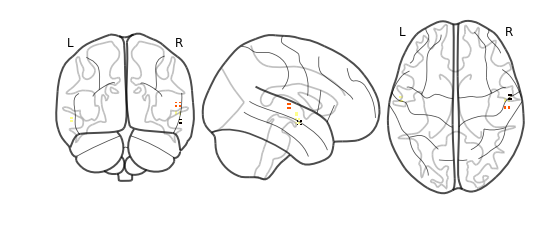

In [29]:
nifi.plot_glass_brain()

In [27]:
coords = top_10[3]

In [90]:
nifi.save(os.path.join(neurosynth_dir, 'try_it'))

In [91]:
data = decoder.decode([os.path.join(neurosynth_dir, 'try_it.nii')], save='../figs/neurosynth_data/decoding_results.txt')

In [92]:
data

,../figs/neurosynth_data/try_it.nii
taste,-0.0067
disgust,-0.0055
emotion,0.0031
auditory,0.0440
pain,-0.0084
somatosensory,-0.0068
conflict,0.0019
switching,-0.0022
inhibition,-0.0013
